# 승촌보 데이터 분석 

* 승촌보 수질 데이터(Seungchonbo.xlsx)   
    * 2012-2022년  
    * 시간 단위 수집 데이터
* 승촌보 유량 데이터(Seungchonbo_flow.xlsx)
    * 2012-2022년
    * 10분 단위 수집 데이터

## 필요한 모듈 임포트

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## matplotlib 한글 설정  
* 운영체제에 따른 한글 지원 설정. 윈도우, 우분투, 구글 코랩 지원. 

In [3]:
import platform
plt.rc('figure', figsize=(10, 6))  # 그림 크기 설정
if platform.system() == 'Windows': # 윈도우
    from matplotlib import font_manager, rc
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = font_manager.FontProperties(fname=font_path).get_name()
    rc('font', family=font)
elif platform.system() == 'Linux': # 우분투 또는 구글 코랩
    # !sudo apt-get install -y fonts-nanum*
    # !fc-cache -fv
    
    applyfont = "NanumBarunGothic"
    import matplotlib.font_manager as fm
    if not any(map(lambda ft: ft.name == applyfont, fm.fontManager.ttflist)):
        fm.fontManager.addfont("/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf")
    plt.rc("font", family=applyfont)
    plt.rc("axes", unicode_minus=False)

## 승촌보 수질 데이터 불러오기

데이터 저장소

In [4]:
base_path = "https://github.com/codingalzi/water-data/raw/master/reservoirs/"
# base_path = r"C:\Users\owner\Desktop\water-source\data"

승촌보 데이터 불러오기. `'측정일/월'` 특성은 date time으로 파싱.

## 

In [5]:
scb_yearly = pd.read_excel(base_path+"Seungchonbo.xlsx", 
# scb_yearly = pd.read_excel(base_path+"\Seungchonbo.xlsx", 
                            skiprows=0, 
                            header=1, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 측정일/월 특성을 date time으로 파싱

`scb_yearly`는 연도별 데이터프레임을 갖는 사전 자료형.

In [6]:
print(type(scb_yearly))
print('='*50)
print(scb_yearly.keys())
print('='*50)
print(scb_yearly['2013년'].index)
print('='*50)
print(scb_yearly['2013년'].head(3))

<class 'dict'>
dict_keys(['2012년', '2013년', '2014년', '2015년', '2016년', '2017년', '2018년', '2019년', '2020년', '2021년', '2022년'])
RangeIndex(start=0, stop=8750, step=1)
                측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
0 2013-01-01 00:00:00   용봉   3.9     6.9        374.0       11.4         2.5   
1 2013-01-01 01:00:00   용봉   3.9     6.9        375.0       11.4         2.5   
2 2013-01-01 02:00:00   용봉   4.0     6.9        374.0       11.4         2.5   

   총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
0       NaN      NaN          7.2  
1       NaN      NaN          6.9  
2       NaN      NaN          6.8  


연도별 특성은 모두 동일하며 다음과 같다.

In [7]:
print(scb_yearly['2013년'].columns)

Index(['측정일/월', '측정소명', '수온 ℃', '수소이온농도', '전기전도도 μS/cm', '용존산소 mg/L',
       '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '클로로필-a mg/㎥'],
      dtype='object')


`'측정일/월'` 특성을 '년-월-일 시'형식으로 변경한다.

In [8]:
for year in scb_yearly:
    scb_yearly[year]['측정일/월'] = scb_yearly[year]['측정일/월'].apply(lambda x :  x.strftime('%Y-%m-%d %H'))

In [9]:
print(scb_yearly['2013년'].head(3))

           측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
0  2013-01-01 00   용봉   3.9     6.9        374.0       11.4         2.5   
1  2013-01-01 01   용봉   3.9     6.9        375.0       11.4         2.5   
2  2013-01-01 02   용봉   4.0     6.9        374.0       11.4         2.5   

   총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
0       NaN      NaN          7.2  
1       NaN      NaN          6.9  
2       NaN      NaN          6.8  


### 연도별 수질 데이터 통합

2012년도 데이터를 제외한 모든 데이터를 통합

In [10]:
scb_yearly_df13 = pd.DataFrame()

for year in list(scb_yearly.keys())[1:]:
    scb_yearly_df13 = pd.concat([scb_yearly_df13, scb_yearly[year]])

In [11]:
print(scb_yearly_df13.head(3))
print('='*50)
print(scb_yearly_df13.tail(3))

           측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
0  2013-01-01 00   용봉   3.9     6.9        374.0       11.4         2.5   
1  2013-01-01 01   용봉   3.9     6.9        375.0       11.4         2.5   
2  2013-01-01 02   용봉   4.0     6.9        374.0       11.4         2.5   

   총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
0       NaN      NaN          7.2  
1       NaN      NaN          6.9  
2       NaN      NaN          6.8  
              측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
3429  2022-05-23 21   용봉  25.9     6.8        417.0        NaN         6.7   
3430  2022-05-23 22   용봉  25.7     6.8        420.0        NaN         6.4   
3431  2022-05-23 23   용봉  25.5     6.8        411.0        NaN         6.4   

      총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
3429     5.909    0.107         58.3  
3430     5.921    0.106         54.4  
3431     5.818    0.106         52.3  


인덱스 리셋(기존 인덱스는 삭제)

In [12]:
scb_yearly_df13 = scb_yearly_df13.reset_index(drop=True)

In [13]:
print(scb_yearly_df13.head(3))
print('='*50)
print(scb_yearly_df13.tail(3))

           측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
0  2013-01-01 00   용봉   3.9     6.9        374.0       11.4         2.5   
1  2013-01-01 01   용봉   3.9     6.9        375.0       11.4         2.5   
2  2013-01-01 02   용봉   4.0     6.9        374.0       11.4         2.5   

   총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
0       NaN      NaN          7.2  
1       NaN      NaN          6.9  
2       NaN      NaN          6.8  
               측정일/월 측정소명  수온 ℃  수소이온농도  전기전도도 μS/cm  용존산소 mg/L  총유기탄소 mg/L  \
82254  2022-05-23 21   용봉  25.9     6.8        417.0        NaN         6.7   
82255  2022-05-23 22   용봉  25.7     6.8        420.0        NaN         6.4   
82256  2022-05-23 23   용봉  25.5     6.8        411.0        NaN         6.4   

       총질소 mg/L  총인 mg/L  클로로필-a mg/㎥  
82254     5.909    0.107         58.3  
82255     5.921    0.106         54.4  
82256     5.818    0.106         52.3  


기본 정보 확인

In [14]:
scb_yearly_df13.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82257 entries, 0 to 82256
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정일/월        82257 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
dtypes: float64(8), object(2)
memory usage: 6.3+ MB


**결측치 확인**  

측정일과 측정소를 제외한 모든 특성에 다수의 결측치가 포함된다.

In [15]:
scb_yearly_df13.isnull().sum()

측정일/월              0
측정소명               0
수온 ℃           17683
수소이온농도         17696
전기전도도 μS/cm    17733
용존산소 mg/L      19601
총유기탄소 mg/L     23582
총질소 mg/L       22276
총인 mg/L        23260
클로로필-a mg/㎥    19381
dtype: int64

## 승촌보 유량 데이터 추가

`시간` 특성은 date time으로 파싱해서 불러온다.

In [16]:
scb_flow_yearly = pd.read_excel(base_path+"Seungchonbo_flow.xlsx", 
# scb_flow_yearly = pd.read_excel(base_path+"\Seungchonbo_flow.xlsx", 
                            header=0, 
                            sheet_name=None,
                            na_values='ND',
                            parse_dates=[0])  # 시간 특성을 date time으로 파싱

`scb_flow_yearly`도 연도별 데이터프레임을 갖는 사전 자료형이다.

In [17]:
print(type(scb_flow_yearly))
print('='*50)
print(scb_flow_yearly.keys())
print('='*50)
print(scb_flow_yearly['2013'].info())
print('='*50)
print(scb_flow_yearly['2013'].head(3))

<class 'dict'>
dict_keys(['2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022'])
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52560 entries, 0 to 52559
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   시간           52560 non-null  datetime64[ns]
 1    상류수위(EL.m)  52560 non-null  float64       
 2    하류수위(EL.m)  52560 non-null  float64       
 3    유입량(㎥/s)    52560 non-null  float64       
 4    방류량(㎥/s)    52560 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.0 MB
None
                   시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
0 2013-01-01 00:00:00          7.5         3.77      19.82      19.74
1 2013-01-01 00:10:00          7.5         3.77      19.78      19.76
2 2013-01-01 00:20:00          7.5         3.77      19.77      19.82


`시간` 특성을 '년-월-일 시' 형식으로 변경한다. 

In [18]:

for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly[year]['시간'] = scb_flow_yearly[year]['시간'].apply(lambda x : x.strftime('%Y-%m-%d %H'))

In [19]:
print(scb_flow_yearly['2013'].head(3))

              시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
0  2013-01-01 00          7.5         3.77      19.82      19.74
1  2013-01-01 00          7.5         3.77      19.78      19.76
2  2013-01-01 00          7.5         3.77      19.77      19.82


10분 단위로 수집된 수량 데이터를 시간 단위 데이터로 변환한다(시간대별 평균). 단, 데이터가 적은 2012년도 데이터는 무시한다.

In [20]:
scb_flow_yearly_hour = {}

for year in list(scb_flow_yearly.keys())[1:]:
    scb_flow_yearly_hour[year] = scb_flow_yearly[year].groupby('시간').mean()

In [21]:
print(scb_flow_yearly_hour['2013'].head(3))

                상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
시간                                                           
2013-01-01 00          7.5         3.77  19.773333  19.748333
2013-01-01 01          7.5         3.77  19.701667  19.706667
2013-01-01 02          7.5         3.77  19.748333  19.723333


인덱스 추가

In [22]:
for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour[year] = scb_flow_yearly_hour[year].reset_index()

In [23]:
scb_flow_yearly_hour['2013'].head(3)

,시간,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
0,2013-01-01 00,7.5,3.77,19.773333,19.748333
1,2013-01-01 01,7.5,3.77,19.701667,19.706667
2,2013-01-01 02,7.5,3.77,19.748333,19.723333


승촌보 유량 데이터 통합(2013년부터)

In [24]:
scb_flow_yearly_hour_df = pd.DataFrame()

for year in scb_flow_yearly_hour:
    scb_flow_yearly_hour_df = pd.concat([scb_flow_yearly_hour_df, scb_flow_yearly_hour[year]])

In [25]:
print(scb_flow_yearly_hour_df.head(3))
print('='*50)
print(scb_flow_yearly_hour_df.tail(3))

              시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
0  2013-01-01 00          7.5         3.77  19.773333  19.748333
1  2013-01-01 01          7.5         3.77  19.701667  19.706667
2  2013-01-01 02          7.5         3.77  19.748333  19.723333
                 시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
5489  2022-08-17 17     5.483333     1.626667  29.068333  44.878333
5490  2022-08-17 18     5.470000     1.566667  19.131667  14.925000
5491  2022-08-17 19     5.468333     1.581667  18.811667  19.368333


유량 데이터 인덱스 리셋(기존 인덱스 삭제)

In [26]:
scb_flow_yearly_hour_df = scb_flow_yearly_hour_df.reset_index(drop=True)

In [27]:
print(scb_flow_yearly_hour_df.head(3))
print('='*50)
print(scb_flow_yearly_hour_df.tail(3))

              시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
0  2013-01-01 00          7.5         3.77  19.773333  19.748333
1  2013-01-01 01          7.5         3.77  19.701667  19.706667
2  2013-01-01 02          7.5         3.77  19.748333  19.723333
                  시간   상류수위(EL.m)   하류수위(EL.m)   유입량(㎥/s)   방류량(㎥/s)
84351  2022-08-17 17     5.483333     1.626667  29.068333  44.878333
84352  2022-08-17 18     5.470000     1.566667  19.131667  14.925000
84353  2022-08-17 19     5.468333     1.581667  18.811667  19.368333


기본 정보 확인

In [28]:
scb_flow_yearly_hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84354 entries, 0 to 84353
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           84354 non-null  object 
 1    상류수위(EL.m)  84354 non-null  float64
 2    하류수위(EL.m)  84354 non-null  float64
 3    유입량(㎥/s)    84354 non-null  float64
 4    방류량(㎥/s)    84354 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.2+ MB


## 수질/유량 데이터 합병  
수질 데이터와 유량 데이터를 `측정일/월`과 `시간` 기준으로 합병한다.   

* 수질 데이터의 `측정일/월` 특성 이름을 `시간`으로 변경

In [29]:
scb_yearly_df13 = scb_yearly_df13.rename(columns={'측정일/월':'시간'})

In [30]:
scb_yearly_df13.head(3)

,시간,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥
0,2013-01-01 00,용봉,3.9,6.9,374.0,11.4,2.5,NaN,NaN,7.2
1,2013-01-01 01,용봉,3.9,6.9,375.0,11.4,2.5,NaN,NaN,6.9
2,2013-01-01 02,용봉,4.0,6.9,374.0,11.4,2.5,NaN,NaN,6.8


`pd.merge()`에서 `how = 'outer'` 키워드 인자 : 두 데이터에 사용된 모든 시간대의 데이터를 모두 추가한다(합집합).

In [31]:
scb_data = pd.merge(scb_yearly_df13, scb_flow_yearly_hour_df, how='outer')

In [32]:
scb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84380 entries, 0 to 84379
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   시간           84380 non-null  object 
 1   측정소명         82257 non-null  object 
 2   수온 ℃         64574 non-null  float64
 3   수소이온농도       64561 non-null  float64
 4   전기전도도 μS/cm  64524 non-null  float64
 5   용존산소 mg/L    62656 non-null  float64
 6   총유기탄소 mg/L   58675 non-null  float64
 7   총질소 mg/L     59981 non-null  float64
 8   총인 mg/L      58997 non-null  float64
 9   클로로필-a mg/㎥  62876 non-null  float64
 10   상류수위(EL.m)  84354 non-null  float64
 11   하류수위(EL.m)  84354 non-null  float64
 12   유입량(㎥/s)    84354 non-null  float64
 13   방류량(㎥/s)    84354 non-null  float64
dtypes: float64(12), object(2)
memory usage: 9.7+ MB


수질 데이터(~22년5월23일)는 82257개의 데이터 샘플.  
유량 데이터(~22년8월17일)는 84354개의 데이터 샘플

In [33]:
print(scb_yearly_df13.__len__())
print(scb_flow_yearly_hour_df.__len__())

82257
84354


유량 데이터만 있는 일자의 데이터는 삭제

In [34]:
scb_data = scb_data[:len(scb_yearly_df13)]

In [35]:
scb_data.tail(3)

,시간,측정소명,수온 ℃,수소이온농도,전기전도도 μS/cm,용존산소 mg/L,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),하류수위(EL.m),유입량(㎥/s),방류량(㎥/s)
82254,2022-05-23 21,용봉,25.9,6.8,417.0,NaN,6.7,5.909,0.107,58.3,5.44,1.531667,12.753333,12.743333
82255,2022-05-23 22,용봉,25.7,6.8,420.0,NaN,6.4,5.921,0.106,54.4,5.44,1.530000,12.700000,12.700000
82256,2022-05-23 23,용봉,25.5,6.8,411.0,NaN,6.4,5.818,0.106,52.3,5.44,1.525000,12.760000,12.770000


유량 특성 이름에 공백이 사용되었기에 특성명에 공백 제거

In [36]:
scb_data.columns = [x.strip() for x in list(scb_data.columns)]

## 특성 선택

훈련에 사용하지 않을 특성 삭제

In [37]:
scb_data.drop(['수소이온농도', '용존산소 mg/L', '하류수위(EL.m)', '유입량(㎥/s)'], axis=1, inplace=True)

In [38]:
scb_data.columns

Index(['시간', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)'],
      dtype='object')

## 결측치 확인

* 특성별 결측치 비율

In [39]:
scb_data.isnull().sum() / len(scb_data)

시간             0.000000
측정소명           0.000000
수온 ℃           0.214973
전기전도도 μS/cm    0.215580
총유기탄소 mg/L     0.286687
총질소 mg/L       0.270810
총인 mg/L        0.282772
클로로필-a mg/㎥    0.235615
상류수위(EL.m)     0.000316
방류량(㎥/s)       0.000316
dtype: float64

* 결측치 분포 히트맵: 결측치가 한 동안 없는 경우도 존재

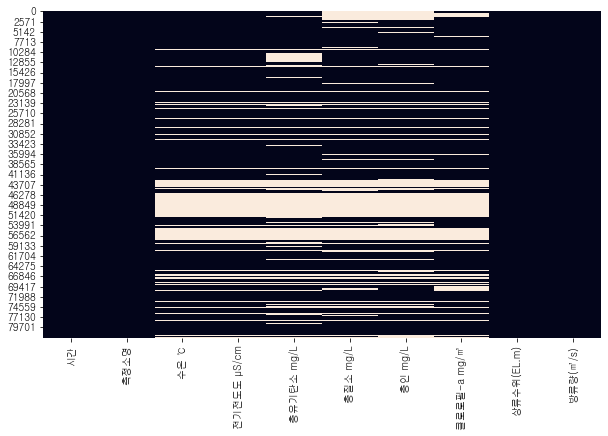

In [40]:
sns.heatmap(scb_data.isnull(), cbar=False)
plt.show()

수치형 특성 결측치들 사이의 피어슨 상관계수 확인 - 어떤 특성들이 함께 결측되었나를 확인함

In [41]:
scb_data_numeric = scb_data.iloc[:, 2:]
scb_data_numeric.isnull().corr(method='pearson')

,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s)
수온 ℃,1.000000,0.997627,0.784735,0.771253,0.753176,0.893317,-0.005975,-0.005975
전기전도도 μS/cm,0.997627,1.000000,0.784629,0.770361,0.752133,0.891512,-0.005996,-0.005996
총유기탄소 mg/L,0.784735,0.784629,1.000000,0.698539,0.677277,0.726571,-0.005223,-0.005223
총질소 mg/L,0.771253,0.770361,0.698539,1.000000,0.884298,0.771919,-0.007758,-0.007758
총인 mg/L,0.753176,0.752133,0.677277,0.884298,1.000000,0.747514,-0.008128,-0.008128
클로로필-a mg/㎥,0.893317,0.891512,0.726571,0.771919,0.747514,1.000000,-0.006649,-0.006649
상류수위(EL.m),-0.005975,-0.005996,-0.005223,-0.007758,-0.008128,-0.006649,1.000000,1.000000
방류량(㎥/s),-0.005975,-0.005996,-0.005223,-0.007758,-0.008128,-0.006649,1.000000,1.000000


## 클로로필 정규화

회귀 모델을 적용하기 전에 클로로필 값이 정규 분포인지 확인. 왼쪽으로 치우친 형태임.

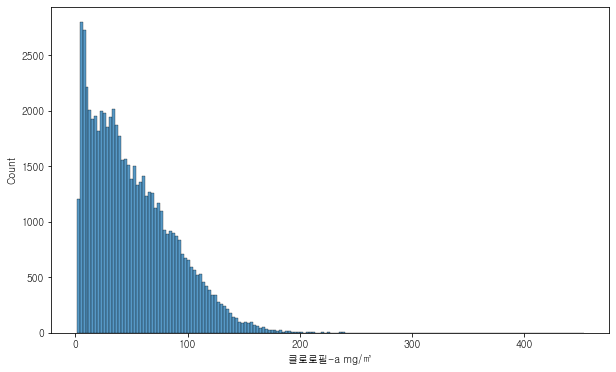

In [42]:
sns.histplot(scb_data['클로로필-a mg/㎥'])
plt.show()

`np.log1p()`를 사용해 로그변환하면 클로로필 값이 정규 분포를 가짐. 

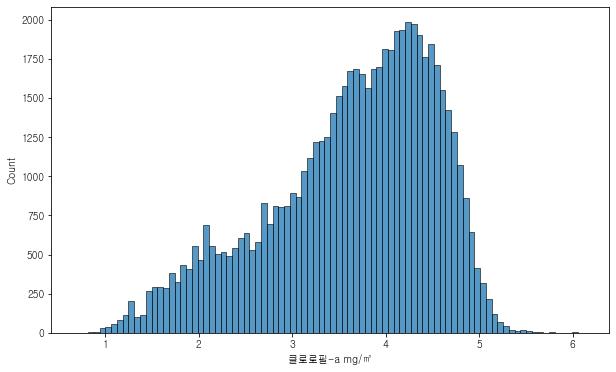

In [43]:
sns.histplot(np.log1p(scb_data['클로로필-a mg/㎥']))
plt.show()

클로로필 값을 로그 변환한 뒤 `scb_data`에 추가

In [44]:
scb_data['log_Chl-a'] = np.log1p(scb_data['클로로필-a mg/㎥'])

In [45]:
scb_data.head(3)

,시간,측정소명,수온 ℃,전기전도도 μS/cm,총유기탄소 mg/L,총질소 mg/L,총인 mg/L,클로로필-a mg/㎥,상류수위(EL.m),방류량(㎥/s),log_Chl-a
0,2013-01-01 00,용봉,3.9,374.0,2.5,NaN,NaN,7.2,7.5,19.748333,2.104134
1,2013-01-01 01,용봉,3.9,375.0,2.5,NaN,NaN,6.9,7.5,19.706667,2.066863
2,2013-01-01 02,용봉,4.0,374.0,2.5,NaN,NaN,6.8,7.5,19.723333,2.054124


## 수온 shift 데이터 추가

In [46]:
scb_df = scb_data.copy()

수온 shift 특성 추가  

* 0 ~ 72시간 : 2시간 단위

In [47]:
shift_step = list(range(2, 73, 2))
print(shift_step)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72]


**shift 특성 추가 함수** 

`feature_shifting()` 함수는 특정 특성을 대상으로 shift 적용한 특성을 추가한다. 함수의 인자로 다음 세 개의 값을 받는다.  
* `df` : 기존 데이터프레임
* `feature` : shift 대상 특성
* `shift_step` : 추가할 shift_step의 리스트 

In [48]:
from pandas import DataFrame
import re

def feature_shifting(df : DataFrame, feature : str, shift_step : list) -> None:
    feature_ = re.split(' |\(', feature)[0] # 특성 이름에 사용된 단위 삭제. 공백 또는 여는 괄호 기준 쪼개기

    new_features = dict()
    for step in shift_step:
        new_features[str(step) + 'shift ' + feature_] = df[feature].shift(step)
    
    new_features = pd.DataFrame(new_features)

    return pd.concat([df, new_features], axis=1)

In [49]:
scb_df = feature_shifting(scb_df, '수온 ℃', shift_step)

In [50]:
scb_df.columns

Index(['시간', '측정소명', '수온 ℃', '전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L',
       '총인 mg/L', '클로로필-a mg/㎥', '상류수위(EL.m)', '방류량(㎥/s)', 'log_Chl-a',
       '2shift 수온', '4shift 수온', '6shift 수온', '8shift 수온', '10shift 수온',
       '12shift 수온', '14shift 수온', '16shift 수온', '18shift 수온', '20shift 수온',
       '22shift 수온', '24shift 수온', '26shift 수온', '28shift 수온', '30shift 수온',
       '32shift 수온', '34shift 수온', '36shift 수온', '38shift 수온', '40shift 수온',
       '42shift 수온', '44shift 수온', '46shift 수온', '48shift 수온', '50shift 수온',
       '52shift 수온', '54shift 수온', '56shift 수온', '58shift 수온', '60shift 수온',
       '62shift 수온', '64shift 수온', '66shift 수온', '68shift 수온', '70shift 수온',
       '72shift 수온'],
      dtype='object')

## 결측치 보간법

In [51]:
from datetime import datetime

시간 특성을 date time 자료형으로 변환

In [52]:
scb_df['시간'] = scb_df['시간'].transform(lambda x: datetime.strptime(x, '%Y-%m-%d %H'))

결측치는 양방향 12시간 선형 보간법으로 대체. 결측 구간별 최대 24시간의 결측치 대체.      
예) 결측치가 36개인 구간이 있다면 처음~12개와 25~36개만 결측치 대체.  

In [53]:
scb_df = scb_df.copy().set_index('시간').interpolate(method='time', limit = 12, limit_direction='both')

결측치 제거

In [54]:
scb_df.dropna(inplace=True)

In [55]:
scb_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56950 entries, 2013-03-29 04:00:00 to 2022-05-23 23:00:00
Data columns (total 46 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   측정소명         56950 non-null  object 
 1   수온 ℃         56950 non-null  float64
 2   전기전도도 μS/cm  56950 non-null  float64
 3   총유기탄소 mg/L   56950 non-null  float64
 4   총질소 mg/L     56950 non-null  float64
 5   총인 mg/L      56950 non-null  float64
 6   클로로필-a mg/㎥  56950 non-null  float64
 7   상류수위(EL.m)   56950 non-null  float64
 8   방류량(㎥/s)     56950 non-null  float64
 9   log_Chl-a    56950 non-null  float64
 10  2shift 수온    56950 non-null  float64
 11  4shift 수온    56950 non-null  float64
 12  6shift 수온    56950 non-null  float64
 13  8shift 수온    56950 non-null  float64
 14  10shift 수온   56950 non-null  float64
 15  12shift 수온   56950 non-null  float64
 16  14shift 수온   56950 non-null  float64
 17  16shift 수온   56950 non-null  float64
 18  18shift 수온 

## 훈련 특성과 타깃  

log_Chl-a 은 타깃. 측정소명과 클로로필을 제외한 특성을 이용.

In [56]:
remove_feature = ['측정소명', '클로로필-a mg/㎥', 'log_Chl-a']

In [57]:
col = list(scb_df.columns)

for i in remove_feature:
    col.remove(i)

## 모델 훈련 - RandomForest

In [58]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.drop(columns=remove_feature), scb_df['log_Chl-a'], random_state=42)
rf_reg = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)

parameters = {'n_estimators':[100, 500], 'max_depth':[5, 10, 15], 'min_samples_leaf':[8, 12, 16]}

In [59]:
rf_grid = GridSearchCV(rf_reg, param_grid=parameters, cv=3, n_jobs=-1, verbose=5)

In [60]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_jobs=-1, oob_score=True,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [8, 12, 16],
                         'n_estimators': [100, 500]},
             verbose=5)

In [61]:
scores_df = pd.DataFrame(rf_grid.cv_results_)

In [62]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
13,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.903189,1
12,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.902471,2
15,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.887533,3
14,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.886590,4
17,"{'max_depth': 15, 'min_samples_leaf': 16, 'n_e...",0.873281,5


In [63]:
rf_grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 8, 'n_estimators': 500}

In [64]:
estimator = rf_grid.best_estimator_

최신 모델 저장

In [65]:
joblib.dump(estimator, "승촌보_rf_수온.pkl")


['승촌보_rf_수온.pkl']

저장된 모델 다시 불러오기

In [66]:
estimator = joblib.load("승촌보_rf_수온.pkl")

In [67]:
estimator.oob_score_

0.9227335846961054

In [68]:
pred = estimator.predict(X_test)

In [69]:
for score, name in zip(estimator.feature_importances_, col):
    print(round(score, 2), name)

0.06 수온 ℃
0.17 전기전도도 μS/cm
0.05 총유기탄소 mg/L
0.06 총질소 mg/L
0.05 총인 mg/L
0.14 상류수위(EL.m)
0.22 방류량(㎥/s)
0.07 2shift 수온
0.02 4shift 수온
0.01 6shift 수온
0.0 8shift 수온
0.0 10shift 수온
0.0 12shift 수온
0.0 14shift 수온
0.0 16shift 수온
0.0 18shift 수온
0.0 20shift 수온
0.0 22shift 수온
0.0 24shift 수온
0.01 26shift 수온
0.0 28shift 수온
0.0 30shift 수온
0.0 32shift 수온
0.0 34shift 수온
0.0 36shift 수온
0.0 38shift 수온
0.0 40shift 수온
0.0 42shift 수온
0.0 44shift 수온
0.0 46shift 수온
0.0 48shift 수온
0.0 50shift 수온
0.0 52shift 수온
0.0 54shift 수온
0.0 56shift 수온
0.0 58shift 수온
0.01 60shift 수온
0.01 62shift 수온
0.01 64shift 수온
0.01 66shift 수온
0.0 68shift 수온
0.01 70shift 수온
0.01 72shift 수온


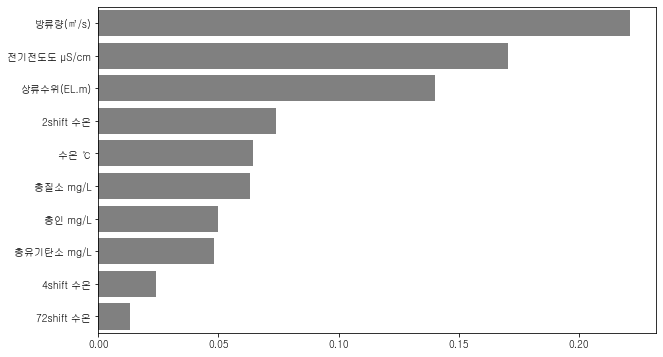

In [70]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [71]:
feature_series[:10]

방류량(㎥/s)       0.221023
전기전도도 μS/cm    0.170562
상류수위(EL.m)     0.139988
2shift 수온      0.073779
수온 ℃           0.064560
총질소 mg/L       0.063034
총인 mg/L        0.049999
총유기탄소 mg/L     0.047975
4shift 수온      0.024226
72shift 수온     0.013409
dtype: float64

In [72]:
print('score :', estimator.score(X_test, y_test))

score : 0.9221647183572951


## 모델 훈련 - GradientBoosting

In [73]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col], scb_df['log_Chl-a'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [74]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [75]:
gb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.741 total time=  33.7s
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.742 total time=  33.7s
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.744 total time=  33.6s
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.928 total time= 1.1min
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.927 total time= 1.1min
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.926 total time= 1.1min
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.938 total time= 1.6min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.942 total time= 1.6min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.938 total time= 1.6min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.791 total time=  33.9s
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.793 total time=  33.8s
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [76]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [77]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.942837,1
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.940677,2
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.939444,3
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.939113,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.937523,5


In [78]:
gb_grid.best_params_

{'learning_rate': 0.2, 'max_depth': 10}

In [79]:
estimator = gb_grid.best_estimator_

**최신 모델 저장**

In [80]:
import joblib

In [81]:
joblib.dump(estimator, "승촌보_gb_수온.pkl")

['승촌보_gb_수온.pkl']

저장된 모델을 다시 불러오기

In [82]:
estimator = joblib.load("승촌보_gb_수온.pkl")

In [83]:
pred = estimator.predict(X_test)

In [84]:
for score, name in zip(estimator.feature_importances_, col):
    print(round(score, 2), name)

0.06 수온 ℃
0.17 전기전도도 μS/cm
0.05 총유기탄소 mg/L
0.06 총질소 mg/L
0.05 총인 mg/L
0.14 상류수위(EL.m)
0.21 방류량(㎥/s)
0.08 2shift 수온
0.02 4shift 수온
0.0 6shift 수온
0.0 8shift 수온
0.0 10shift 수온
0.0 12shift 수온
0.0 14shift 수온
0.0 16shift 수온
0.01 18shift 수온
0.0 20shift 수온
0.0 22shift 수온
0.0 24shift 수온
0.01 26shift 수온
0.0 28shift 수온
0.0 30shift 수온
0.0 32shift 수온
0.0 34shift 수온
0.0 36shift 수온
0.0 38shift 수온
0.01 40shift 수온
0.0 42shift 수온
0.0 44shift 수온
0.0 46shift 수온
0.0 48shift 수온
0.0 50shift 수온
0.0 52shift 수온
0.0 54shift 수온
0.0 56shift 수온
0.01 58shift 수온
0.01 60shift 수온
0.01 62shift 수온
0.01 64shift 수온
0.01 66shift 수온
0.01 68shift 수온
0.0 70shift 수온
0.02 72shift 수온


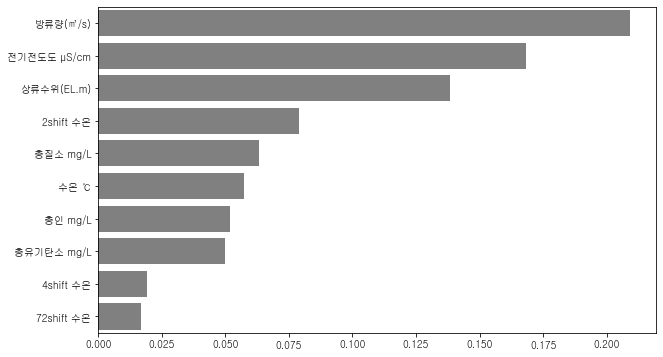

In [85]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [86]:
feature_series[:10]

방류량(㎥/s)       0.208991
전기전도도 μS/cm    0.168133
상류수위(EL.m)     0.138403
2shift 수온      0.078975
총질소 mg/L       0.063097
수온 ℃           0.057175
총인 mg/L        0.051925
총유기탄소 mg/L     0.049896
4shift 수온      0.019267
72shift 수온     0.016908
dtype: float64

In [87]:
print('score :', estimator.score(X_test, y_test))

score : 0.9570012244066335


## shift수온 + 방류량 데이터만

In [88]:
col_v = ['방류량(㎥/s)']

for i in col:
    if '수온' in i:
        col_v.append(i)

In [89]:
print(col_v)

['방류량(㎥/s)', '수온 ℃', '2shift 수온', '4shift 수온', '6shift 수온', '8shift 수온', '10shift 수온', '12shift 수온', '14shift 수온', '16shift 수온', '18shift 수온', '20shift 수온', '22shift 수온', '24shift 수온', '26shift 수온', '28shift 수온', '30shift 수온', '32shift 수온', '34shift 수온', '36shift 수온', '38shift 수온', '40shift 수온', '42shift 수온', '44shift 수온', '46shift 수온', '48shift 수온', '50shift 수온', '52shift 수온', '54shift 수온', '56shift 수온', '58shift 수온', '60shift 수온', '62shift 수온', '64shift 수온', '66shift 수온', '68shift 수온', '70shift 수온', '72shift 수온']


## 모델 훈련 - RandomForest(shift수온 + 방류량)

In [90]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_v], scb_df['log_Chl-a'], random_state=42)
rf_reg = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)

parameters = {'n_estimators':[100, 500], 'max_depth':[5, 10, 15], 'min_samples_leaf':[8, 12, 16]}

In [91]:
rf_grid = GridSearchCV(rf_reg, param_grid=parameters, cv=3, n_jobs=-1, verbose=5)

In [92]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_jobs=-1, oob_score=True,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [8, 12, 16],
                         'n_estimators': [100, 500]},
             verbose=5)

In [93]:
scores_df = pd.DataFrame(rf_grid.cv_results_)

In [94]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
13,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.696213,1
12,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.693913,2
15,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.674208,3
14,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.671974,4
17,"{'max_depth': 15, 'min_samples_leaf': 16, 'n_e...",0.655448,5


In [95]:
rf_grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 8, 'n_estimators': 500}

In [96]:
estimator = rf_grid.best_estimator_

최신 모델 저장

In [97]:
joblib.dump(estimator, "승촌보_rf_only수온_방류량.pkl")


['승촌보_rf_only수온_방류량.pkl']

저장된 모델 다시 불러오기

In [98]:
estimator = joblib.load("승촌보_rf_only수온_방류량.pkl")

In [99]:
estimator.oob_score_

0.7306566371546388

In [100]:
pred = estimator.predict(X_test)

In [101]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.42 방류량(㎥/s)
0.1 수온 ℃
0.07 2shift 수온
0.03 4shift 수온
0.02 6shift 수온
0.01 8shift 수온
0.01 10shift 수온
0.01 12shift 수온
0.01 14shift 수온
0.01 16shift 수온
0.01 18shift 수온
0.01 20shift 수온
0.01 22shift 수온
0.01 24shift 수온
0.01 26shift 수온
0.01 28shift 수온
0.01 30shift 수온
0.01 32shift 수온
0.01 34shift 수온
0.01 36shift 수온
0.01 38shift 수온
0.01 40shift 수온
0.01 42shift 수온
0.01 44shift 수온
0.01 46shift 수온
0.01 48shift 수온
0.01 50shift 수온
0.01 52shift 수온
0.01 54shift 수온
0.01 56shift 수온
0.01 58shift 수온
0.01 60shift 수온
0.01 62shift 수온
0.01 64shift 수온
0.01 66shift 수온
0.01 68shift 수온
0.01 70shift 수온
0.03 72shift 수온


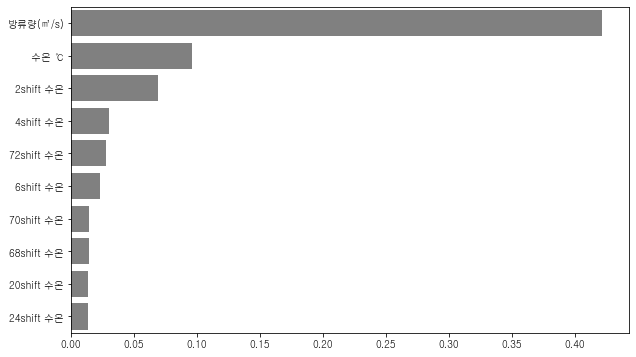

In [102]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [103]:
feature_series[:10]

방류량(㎥/s)      0.421647
수온 ℃          0.095918
2shift 수온     0.069155
4shift 수온     0.030120
72shift 수온    0.027846
6shift 수온     0.022897
70shift 수온    0.014053
68shift 수온    0.013945
20shift 수온    0.013910
24shift 수온    0.013634
dtype: float64

In [104]:
print('score :', estimator.score(X_test, y_test))

score : 0.7301860411749305


## 모델 훈련 - GradientBoosting(shift수온+방류량)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_v], scb_df['log_Chl-a'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [106]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [107]:
gb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.526 total time=  28.5s
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.515 total time=  28.6s
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.518 total time=  28.7s
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.718 total time=  56.4s
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.706 total time=  56.8s
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.713 total time=  56.6s
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.790 total time= 1.4min
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.776 total time= 1.4min
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.768 total time= 1.4min
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.560 total time=  28.5s
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.551 total time=  28.4s
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [108]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [109]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.783220,1
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.777931,2
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.777579,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.760120,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.738248,5


In [110]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [111]:
estimator = gb_grid.best_estimator_

최신 모델 저장

In [112]:
joblib.dump(estimator, "승촌보_gb_only수온_방류량.pkl")

['승촌보_gb_only수온_방류량.pkl']

저장된 모델을 다시 불러오기

In [113]:
estimator = joblib.load("승촌보_gb_only수온_방류량.pkl")

In [114]:
pred = estimator.predict(X_test)

In [115]:
for score, name in zip(estimator.feature_importances_, col_v):
    print(round(score, 2), name)

0.36 방류량(㎥/s)
0.1 수온 ℃
0.04 2shift 수온
0.04 4shift 수온
0.02 6shift 수온
0.01 8shift 수온
0.01 10shift 수온
0.01 12shift 수온
0.01 14shift 수온
0.01 16shift 수온
0.02 18shift 수온
0.02 20shift 수온
0.01 22shift 수온
0.01 24shift 수온
0.01 26shift 수온
0.01 28shift 수온
0.01 30shift 수온
0.01 32shift 수온
0.01 34shift 수온
0.01 36shift 수온
0.01 38shift 수온
0.01 40shift 수온
0.01 42shift 수온
0.01 44shift 수온
0.01 46shift 수온
0.01 48shift 수온
0.01 50shift 수온
0.01 52shift 수온
0.01 54shift 수온
0.02 56shift 수온
0.01 58shift 수온
0.01 60shift 수온
0.01 62shift 수온
0.01 64shift 수온
0.02 66shift 수온
0.02 68shift 수온
0.02 70shift 수온
0.04 72shift 수온


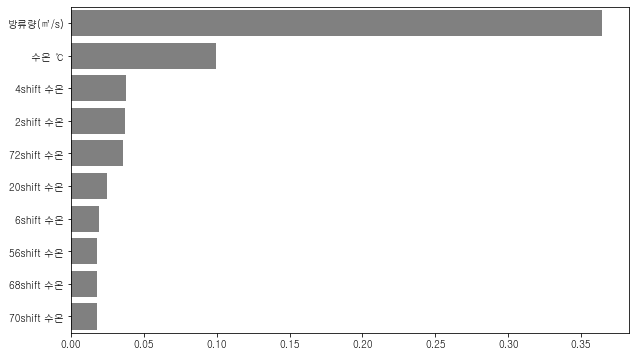

In [116]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_v)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [117]:
feature_series[:10]

방류량(㎥/s)      0.364591
수온 ℃          0.099726
4shift 수온     0.038093
2shift 수온     0.037054
72shift 수온    0.035487
20shift 수온    0.024554
6shift 수온     0.019544
56shift 수온    0.018037
68shift 수온    0.017890
70shift 수온    0.017743
dtype: float64

In [118]:
print('score :', estimator.score(X_test, y_test))

score : 0.8306539060515679


## 전체 + 수온대신 2shift수온만

In [119]:
col_2 = ['전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)', '2shift 수온']
print(col_2)

['전기전도도 μS/cm', '총유기탄소 mg/L', '총질소 mg/L', '총인 mg/L', '상류수위(EL.m)', '방류량(㎥/s)', '2shift 수온']


## 모델 훈련 - RandomForest(전체 + 수온대신 2shift수온)

In [120]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_2], scb_df['log_Chl-a'], random_state=42)
rf_reg = RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1)

parameters = {'n_estimators':[100, 500], 'max_depth':[5, 10, 15], 'min_samples_leaf':[8, 12, 16]}

In [121]:
rf_grid = GridSearchCV(rf_reg, param_grid=parameters, cv=3, n_jobs=-1, verbose=5)

In [122]:
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_jobs=-1, oob_score=True,
                                             random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15],
                         'min_samples_leaf': [8, 12, 16],
                         'n_estimators': [100, 500]},
             verbose=5)

In [123]:
scores_df = pd.DataFrame(rf_grid.cv_results_)

In [124]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
13,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.884662,1
12,"{'max_depth': 15, 'min_samples_leaf': 8, 'n_es...",0.884253,2
15,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.867694,3
14,"{'max_depth': 15, 'min_samples_leaf': 12, 'n_e...",0.867318,4
17,"{'max_depth': 15, 'min_samples_leaf': 16, 'n_e...",0.852850,5


In [125]:
rf_grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 8, 'n_estimators': 500}

In [126]:
estimator = rf_grid.best_estimator_

최신 모델 저장

In [127]:
joblib.dump(estimator, "승촌보_rf_2shift수온.pkl")

['승촌보_rf_2shift수온.pkl']

저장된 모델 다시 불러오기

In [128]:
estimator = joblib.load("승촌보_rf_2shift수온.pkl")

In [129]:
estimator.oob_score_

0.9030601377760745

In [130]:
pred = estimator.predict(X_test)

In [131]:
for score, name in zip(estimator.feature_importances_, col_2):
    print(round(score, 2), name)

0.18 전기전도도 μS/cm
0.06 총유기탄소 mg/L
0.08 총질소 mg/L
0.07 총인 mg/L
0.15 상류수위(EL.m)
0.23 방류량(㎥/s)
0.22 2shift 수온


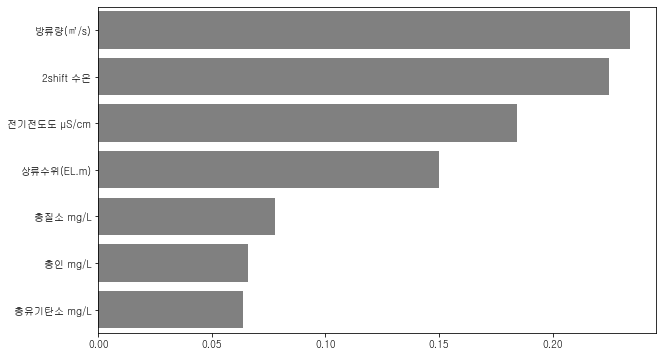

In [132]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_2)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [133]:
feature_series[:10]

방류량(㎥/s)       0.233856
2shift 수온      0.224564
전기전도도 μS/cm    0.184187
상류수위(EL.m)     0.150119
총질소 mg/L       0.077781
총인 mg/L        0.065858
총유기탄소 mg/L     0.063636
dtype: float64

In [134]:
print('score :', estimator.score(X_test, y_test))

score : 0.9008286966361575


## 모델 훈련 - GradientBoosting(전체 + 수온대신 2shift수온)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(scb_df.loc[:, col_2], scb_df['log_Chl-a'], random_state=42)
gb_reg = GradientBoostingRegressor(random_state=42)

parameters = {'max_depth':[5, 10, 15], 'learning_rate':[0.05, 0.1, 0.2]}

In [136]:
gb_grid = GridSearchCV(gb_reg, param_grid=parameters, cv=3, verbose=5)

In [137]:
gb_grid.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END ...learning_rate=0.05, max_depth=5;, score=0.730 total time=   7.2s
[CV 2/3] END ...learning_rate=0.05, max_depth=5;, score=0.728 total time=   7.2s
[CV 3/3] END ...learning_rate=0.05, max_depth=5;, score=0.726 total time=   7.2s
[CV 1/3] END ..learning_rate=0.05, max_depth=10;, score=0.902 total time=  14.0s
[CV 2/3] END ..learning_rate=0.05, max_depth=10;, score=0.901 total time=  14.0s
[CV 3/3] END ..learning_rate=0.05, max_depth=10;, score=0.904 total time=  14.0s
[CV 1/3] END ..learning_rate=0.05, max_depth=15;, score=0.925 total time=  20.2s
[CV 2/3] END ..learning_rate=0.05, max_depth=15;, score=0.924 total time=  20.2s
[CV 3/3] END ..learning_rate=0.05, max_depth=15;, score=0.921 total time=  20.2s
[CV 1/3] END ....learning_rate=0.1, max_depth=5;, score=0.771 total time=   7.2s
[CV 2/3] END ....learning_rate=0.1, max_depth=5;, score=0.767 total time=   7.2s
[CV 3/3] END ....learning_rate=0.1, max_depth=5;,

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             param_grid={'learning_rate': [0.05, 0.1, 0.2],
                         'max_depth': [5, 10, 15]},
             verbose=5)

In [138]:
scores_df = pd.DataFrame(gb_grid.cv_results_)

In [139]:
scores_df.sort_values(by=['rank_test_score'], inplace=True)
scores_df[['params', 'mean_test_score', 'rank_test_score']].head()

,params,mean_test_score,rank_test_score
5,"{'learning_rate': 0.1, 'max_depth': 15}",0.925326,1
8,"{'learning_rate': 0.2, 'max_depth': 15}",0.923433,2
2,"{'learning_rate': 0.05, 'max_depth': 15}",0.923265,3
7,"{'learning_rate': 0.2, 'max_depth': 10}",0.921117,4
4,"{'learning_rate': 0.1, 'max_depth': 10}",0.914253,5


In [140]:
gb_grid.best_params_

{'learning_rate': 0.1, 'max_depth': 15}

In [141]:
estimator = gb_grid.best_estimator_

최신 모델 저장

In [142]:
joblib.dump(estimator, "승촌보_gb_2shift수온.pkl")

['승촌보_gb_2shift수온.pkl']

저장된 모델을 다시 불러오기

In [143]:
estimator = joblib.load("승촌보_gb_2shift수온.pkl")

In [144]:
pred = estimator.predict(X_test)

In [145]:
for score, name in zip(estimator.feature_importances_, col_2):
    print(round(score, 2), name)

0.18 전기전도도 μS/cm
0.07 총유기탄소 mg/L
0.08 총질소 mg/L
0.07 총인 mg/L
0.15 상류수위(EL.m)
0.22 방류량(㎥/s)
0.22 2shift 수온


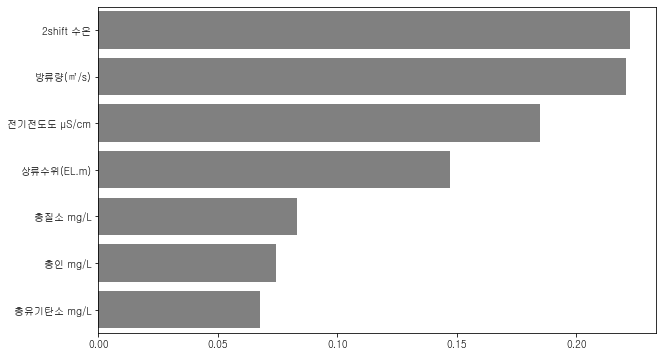

In [146]:
feature_series = pd.Series(data = estimator.feature_importances_, index = col_2)
feature_series = feature_series.sort_values(ascending = False)
sns.barplot(x = feature_series[:10], y = feature_series.index[:10], color = 'gray')
plt.show()

In [147]:
feature_series[:10]

2shift 수온      0.222313
방류량(㎥/s)       0.220934
전기전도도 μS/cm    0.184726
상류수위(EL.m)     0.146993
총질소 mg/L       0.083101
총인 mg/L        0.074299
총유기탄소 mg/L     0.067634
dtype: float64

In [148]:
print('score :', estimator.score(X_test, y_test))

score : 0.9447886142140157
